<a href="https://colab.research.google.com/github/acg12/AlgoBC_DeepLearning_FinalProject/blob/main/notebooks/02_Data_Understanding_and_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # splitting train and validation data

# For visualizing images
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import random
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import os

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load and Data

In [14]:
df = pd.read_csv('/content/drive/MyDrive/Bootcamp/Bootcamp 4/Chest_xray_Corona_Metadata.csv')
df.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [15]:
train_df = df[df['Dataset_type'] == 'TRAIN']
test_df = df[df['Dataset_type'] == 'TEST']
print(train_df.shape)
print(test_df.shape)

(5286, 6)
(624, 6)


In [16]:
TRAIN_DIR = '/content/drive/MyDrive/Bootcamp/Bootcamp 4/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
TEST_DIR = '/content/drive/MyDrive/Bootcamp/Bootcamp 4/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'

# Data Understanding

In [17]:
train_df.isnull().sum()

Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5217
Label_1_Virus_category    1342
dtype: int64

Let's see what kind of data is inside columns Label_2_Virus_category and Label_1_Virus_category.

In [18]:
train_df['Label_1_Virus_category'].value_counts()

bacteria          2535
Virus             1407
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: int64

In [19]:
train_df['Label_2_Virus_category'].value_counts()

COVID-19         58
Streptococcus     5
SARS              4
ARDS              2
Name: Label_2_Virus_category, dtype: int64

These two columns tell us the cause of disease (if the person is indeed infected). Let's fill those null values with "Unknown".

In [20]:
# Fill null values with "Unknown"
filled_train_df = train_df.fillna('Unknown')
filled_test_df = test_df.fillna('Unknown')

# Exploratory Data Analysis

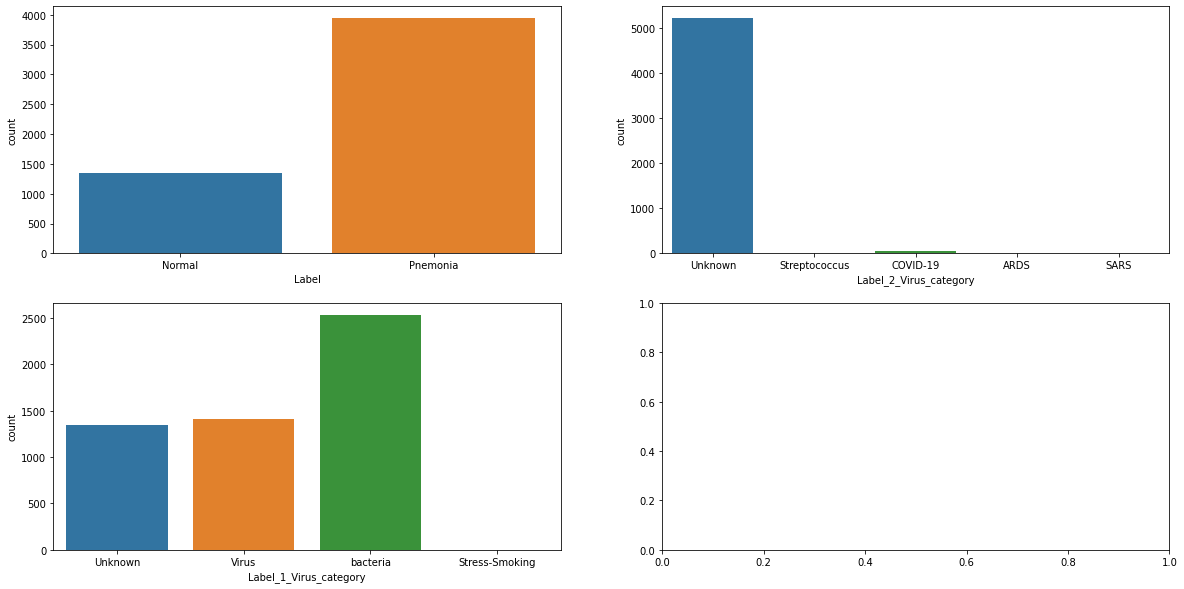

In [21]:
targets = ['Label', 'Label_2_Virus_category', 'Label_1_Virus_category']
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.countplot(x=targets[0], data=filled_train_df, ax=ax[0, 0])
sns.countplot(x=targets[1], data=filled_train_df, ax=ax[0, 1])
sns.countplot(x=targets[2], data=filled_train_df, ax=ax[1, 0])
plt.show()

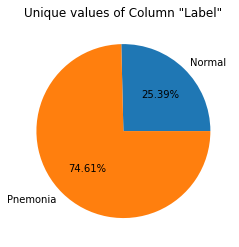

In [22]:
counts = [len(filled_train_df[filled_train_df['Label'] == 'Normal']),
         len(filled_train_df[filled_train_df['Label'] == 'Pnemonia'])]
plt.pie(counts, labels=['Normal', 'Pnemonia'], autopct='%.2f%%')
plt.title('Unique values of Column "Label"')
plt.show()

The data is quite imbalanced.

In [23]:
# Check if there are any weird data (e.g. Normal but Label_1 & Label_2 are known)
condition = (filled_train_df['Label'] == 'Normal') & ((filled_train_df['Label_1_Virus_category'] != 'Unknown') | (filled_train_df['Label_2_Virus_category'] != 'Unknown'))
filled_train_df[condition]

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category


So, it seems there aren't any "weird" data lying around.

## Visualizing samples

In [24]:
def view_image(target_folder, target_img, target_class):
    target_dir = target_folder + "/" + target_img
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_dir)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}") # show the shape of the image

Image shape: (1287, 1870)


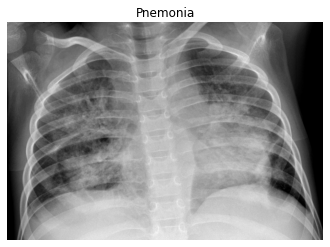

In [25]:
row = filled_train_df.sample(1)
view_image(TRAIN_DIR, row['X_ray_image_name'].values[0], row['Label'].values[0])

If you run the cell a few times, you'll see that the images' shapes vary, they don't have the same shape, so we will have to resize them later.

## Image Histograms

Now, let's look at the histogram distribution of some of the images.

In [26]:
def plot_sample_hists(folder_dir, file_paths, target_class):
    # Plot b/w image histograms of Label type "Normal" patients 
    fig, ax = plt.subplots(4, 2, figsize=(20, 20))

    sample_file_paths = random.sample(list(file_paths), 4)
    sample_file_paths = list(map(lambda x: os.path.join(folder_dir, x), sample_file_paths))

    for row, file_path in enumerate(sample_file_paths):
        image = plt.imread(file_path)
        ax[row, 0].imshow(image, cmap='gray', vmin=0, vmax=255)
        ax[row, 1].hist(image.ravel(), 256, [0,256])
        ax[row, 0].axis('off')
        if row == 0:
            ax[row, 0].set_title('Images')
            ax[row, 1].set_title('Histograms')
    fig.suptitle('Label = ' + target_class, size=16)
    plt.show()

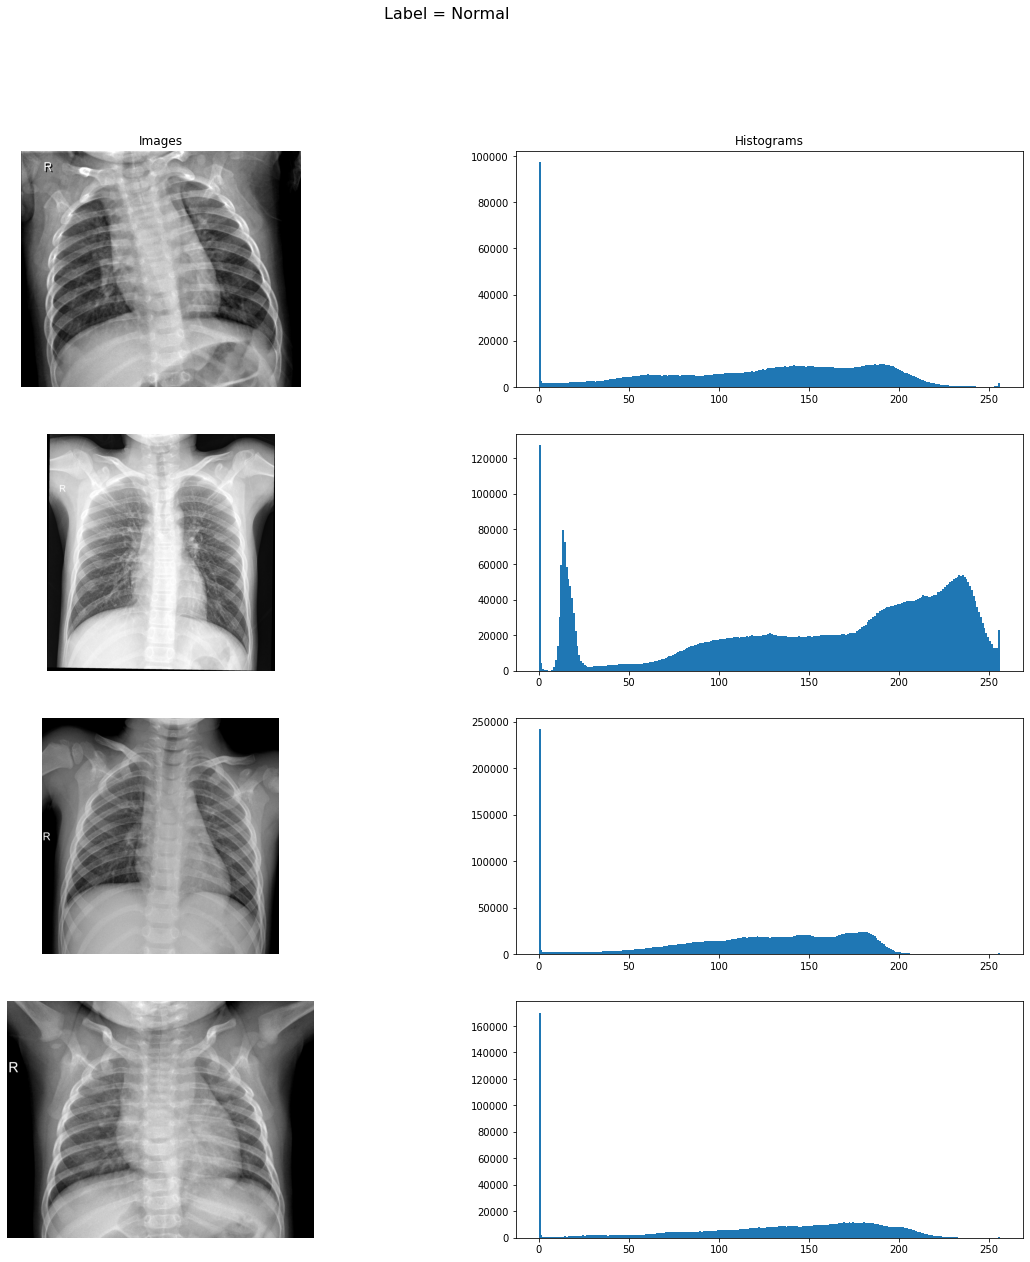

In [27]:
normal_train_df = filled_train_df[filled_train_df['Label'] == 'Normal']
pnemonia_train_df = filled_train_df[filled_train_df['Label'] == 'Pnemonia']

plot_sample_hists(TRAIN_DIR, normal_train_df['X_ray_image_name'].values, 'Normal')

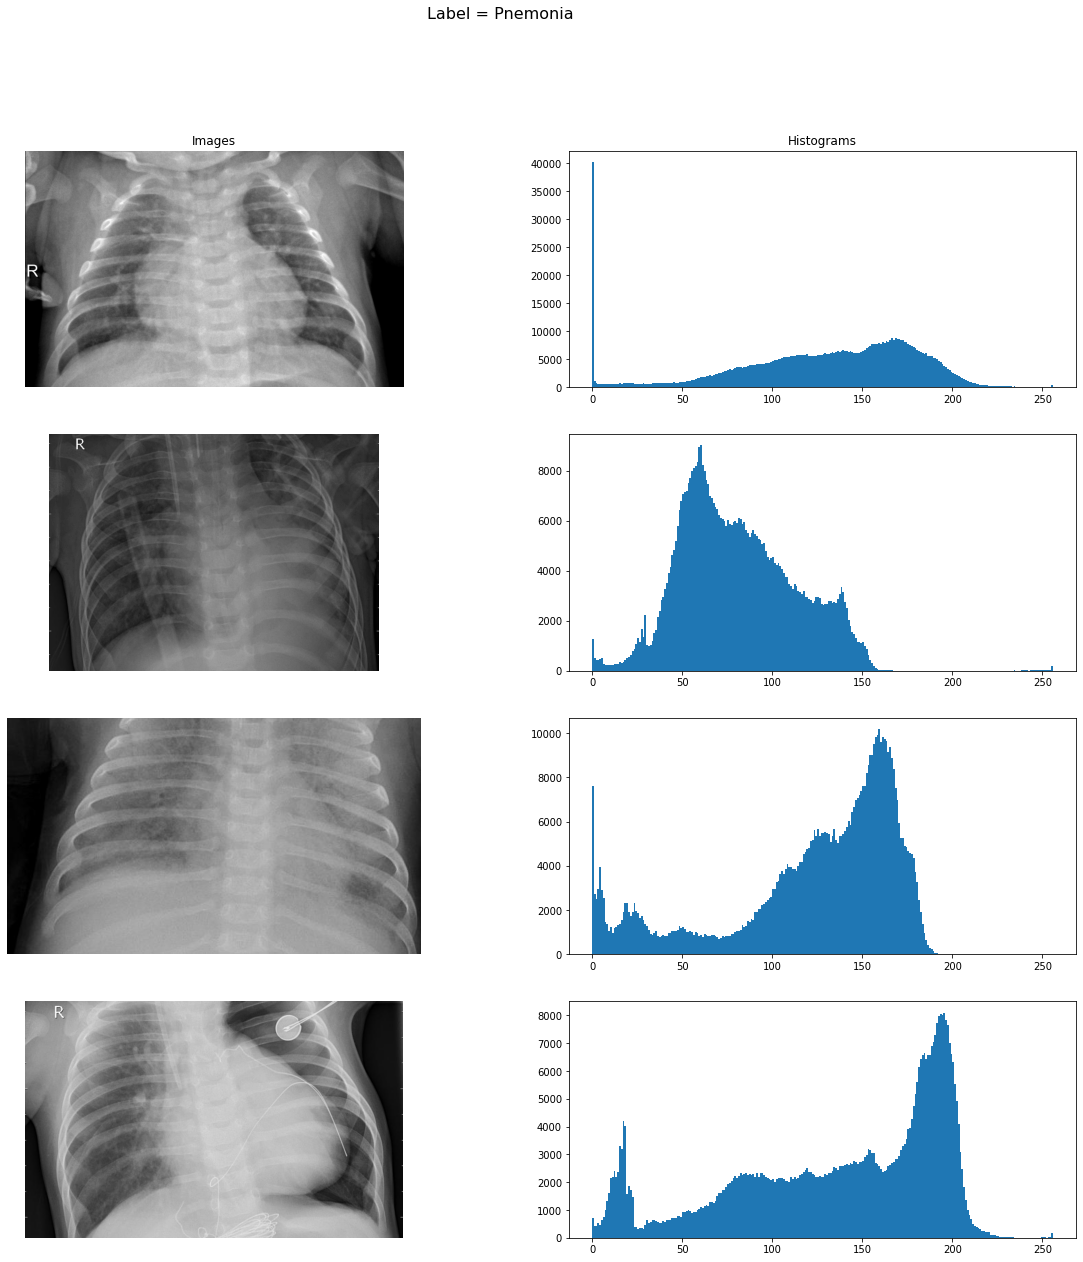

In [29]:
plot_sample_hists(TRAIN_DIR, pnemonia_train_df['X_ray_image_name'].values, 'Pnemonia')

We can see the differences between these two groups of images. Normal lungs typically have **left-skewed** histograms, while lungs infected by COVID-19 typically have **right-skewed** histograms.